# MODEL INFERENCE NOTEBOOK - CHALLENGE - PART 2 - BINARY CLASSIFICATION

**Author:** Sushmetha S R – VIT Chennai  
**Team Name:** *expendables*  
**Team Members:** Abhinav Chaitanya R, Arjun M, Harshavardhan S, Kiranchandran H, Sushmetha S R  
**Leaderboard Rank:** 18  


# This is the notebook used for making the inferences using the model trained.

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import json

## Define Paths
We define the file paths for the training, validation, and test datasets.
- `train_dir` and `train_csv`: Training images and labels (all soil images).
- `test_dir` and `test_csv`: Test images (mix of soil and non-soil).

## Load Metadata and Split Data
- Load the training metadata from `train_labels.csv`.
- Split the training data into training (80%) and validation (20%) sets to compute a threshold for classification.

In [2]:
# Paths
train_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train"
test_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test"
train_csv = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv"
test_csv = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv"

# Load metadata
test_ids = pd.read_csv(test_csv)
train_ids = pd.read_csv(train_csv)

# Split training data into train and validation sets (80-20 split)
train_ids_subset, val_ids_subset = train_test_split(train_ids, test_size=0.2, random_state=42)
print(f"Training subset: {len(train_ids_subset)} images")
print(f"Validation subset: {len(val_ids_subset)} images")

Training subset: 977 images
Validation subset: 245 images


## Define Image Transformations
- Resize images to 224x224 (required by EfficientNet-B0).
- Convert images to tensors and normalize using ImageNet statistics.

In [3]:
# Data transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Create Dataset Class
The `SoilDataset` class loads images, skips invalid ones, and applies transformations.
- Input: DataFrame with image IDs, directory path, and optional transforms.
- Output: Transformed image and image ID.

In [4]:
# Dataset Class
class SoilDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.valid_indices = []
        for idx in range(len(self.df)):
            img_id = self.df.iloc[idx]['image_id']
            img_path = os.path.join(self.data_dir, img_id)
            try:
                with Image.open(img_path) as img:
                    img.convert('RGB')
                self.valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping invalid image {img_path}: {e}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_id = self.df.iloc[actual_idx]['image_id']
        img_path = os.path.join(self.data_dir, img_id)
        with Image.open(img_path) as img:
            image = img.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_id

## Create Datasets and DataLoaders
- Create datasets for training, validation, and test sets.
- Use DataLoaders for batch processing during feature extraction.

In [5]:
# Create datasets and dataloaders
train_dataset = SoilDataset(train_ids_subset, train_dir, transform=transform)
val_dataset = SoilDataset(val_ids_subset, train_dir, transform=transform)
test_dataset = SoilDataset(test_ids, test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

## Load Pretrained Model
- Use EfficientNet-B0 pretrained on ImageNet.
- Replace the classifier with an identity layer to output 1280-D features.

In [6]:
# Load pretrained EfficientNet-B0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier = nn.Identity()
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 77.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Extract Features
Define a function to extract features from the dataset using the pretrained model.
- Input: DataLoader.
- Output: Feature embeddings (1280-D) and corresponding image IDs.

In [7]:
# Extract features
def extract_features(model, loader, desc):
    features = []
    img_ids = []
    with torch.no_grad():
        for imgs, ids in tqdm(loader, desc=desc):
            imgs = imgs.to(device)
            feats = model(imgs)
            features.append(feats.cpu().numpy())
            img_ids.extend(ids)
    return np.concatenate(features, axis=0), img_ids


# Extract features for training, validation, and test sets
train_features, train_img_ids = extract_features(model, train_loader, "Extracting Features (Train)")
val_features, val_img_ids = extract_features(model, val_loader, "Extracting Features (Val)")
test_features, test_img_ids = extract_features(model, test_loader, "Extracting Features (Test)")

Extracting Features (Test): 100%|██████████| 31/31 [00:59<00:00,  1.92s/it]


## Apply PCA
Reduce the dimensionality of features from 1280 to 100 for faster similarity computation.
- Fit PCA on training features.
- Transform training, validation, and test features.

In [8]:
pca = PCA(n_components=100, random_state=42)
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)
test_features_pca = pca.transform(test_features)
print(f"PCA explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

PCA explained variance ratio: 0.8984


## Compute Cosine Similarities
Define a function to compute the average cosine similarity to the top-k training prototypes.
- Input: Test features, training features, and k (number of prototypes).
- Output: Average similarity scores.

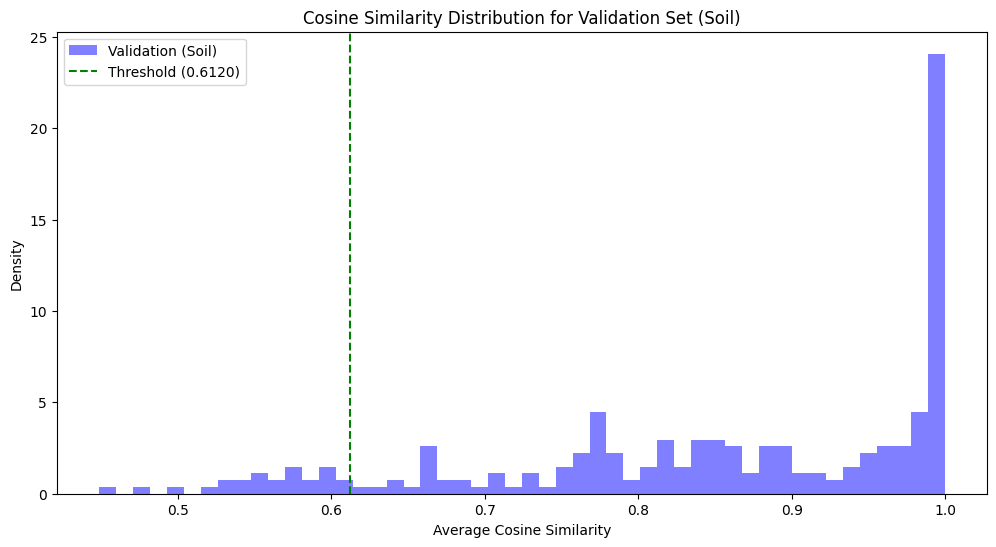

In [9]:
# Define function to compute cosine similarities to training prototypes
def compute_top_k_similarity(test_feats, train_feats, k=5):
    similarities = cosine_similarity(test_feats, train_feats)
    top_k_similarities = np.sort(similarities, axis=1)[:, -k:]
    avg_similarities = np.mean(top_k_similarities, axis=1)
    return avg_similarities

# Compute similarities for validation and test sets
k = 5
val_similarities = compute_top_k_similarity(val_features_pca, train_features_pca, k=k)
test_similarities = compute_top_k_similarity(test_features_pca, train_features_pca, k=k)


# Set Classification Threshold and Visualize the similarity distribution.
plt.figure(figsize=(12, 6))
plt.hist(val_similarities, bins=50, color='blue', alpha=0.5, label='Validation (Soil)', density=True)
plt.title('Cosine Similarity Distribution for Validation Set (Soil)')
plt.xlabel('Average Cosine Similarity')
plt.ylabel('Density')
plt.legend()

threshold = np.percentile(val_similarities, 10)
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.legend()
plt.savefig('similarity_distribution_validation.png', bbox_inches='tight', dpi=300)
plt.show()

## Classify Test Images and Save Submission
- Use the computed threshold to classify test images.
- Higher similarity scores (>= threshold) are classified as soil (label=1), otherwise non-soil (label=0).
- Create a submission file with image IDs and predicted labels.
- Format: `image_id`, `label` (0=non-soil, 1=soil).

In [10]:
test_preds = [1 if sim >= threshold else 0 for sim in test_similarities]

submission = pd.DataFrame({'image_id': test_img_ids, 'label': test_preds})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print(submission.head())

Submission file created: submission.csv
                               image_id  label
0  6595f1266325552489c7d1635fafb88f.jpg      1
1  4b614841803d5448b59e2c6ca74ea664.jpg      1
2  ca30e008692a50638b43d944f46245c8.jpg      1
3  6a9046a219425f7599729be627df1c1a.jpg      1
4  97c1e0276d2d5c2f88dddbc87357611e.jpg      1


## Predict on Test Image and Unseen Images
- Check the prediction for a specific test image (`022fa6c0e0af5aa8af770e1a5927f993.jpg`).
- Visualize the image with its similarity score and prediction.
- Test the model on unseen images (`rocks.png` and `sea.jpeg`), which are expected to be non-soil (label=0).
- Visualize the images with their similarity scores and predictions.

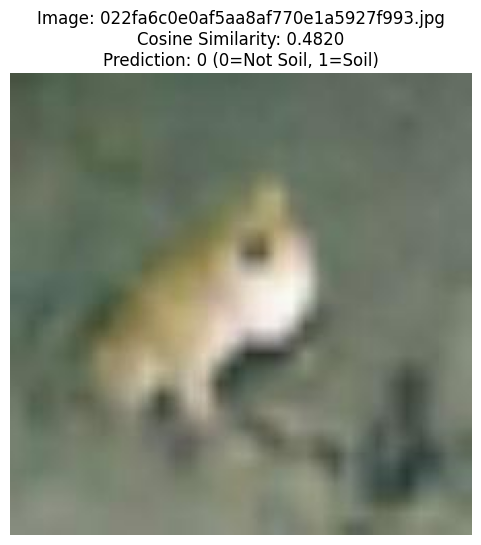

Previous Image: 022fa6c0e0af5aa8af770e1a5927f993.jpg, Cosine Similarity: 0.4820, Prediction: 0 (0=Not Soil, 1=Soil)


In [11]:
# Check prediction for previous specific image
previous_image_id = '022fa6c0e0af5aa8af770e1a5927f993.jpg'
try:
    specific_idx = test_ids[test_ids['image_id'] == previous_image_id].index[0]
    specific_img_id = test_img_ids[specific_idx]
    specific_similarity = test_similarities[specific_idx]
    specific_label = test_preds[specific_idx]

    specific_img_path = os.path.join(test_dir, specific_img_id)
    with Image.open(specific_img_path) as img:
        specific_image = img.convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(specific_image)
    plt.title(f"Image: {specific_img_id}\nCosine Similarity: {specific_similarity:.4f}\nPrediction: {specific_label} (0=Not Soil, 1=Soil)")
    plt.axis('off')
    plt.show()

    print(f"Previous Image: {specific_img_id}, Cosine Similarity: {specific_similarity:.4f}, Prediction: {specific_label} (0=Not Soil, 1=Soil)")
except Exception as e:
    print(f"Error processing specific image: {e}")

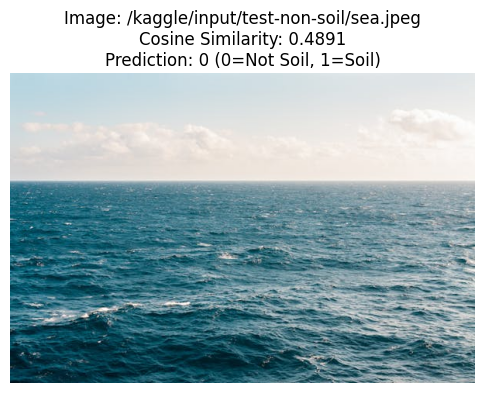

Unseen Image: /kaggle/input/test-non-soil/sea.jpeg, Cosine Similarity: 0.4891, Prediction: 0 (0=Not Soil, 1=Soil)


In [13]:
# Check prediction for unseen image (sea.jpeg)
unseen_image_path = "/kaggle/input/test-non-soil/sea.jpeg"
try:
    with Image.open(unseen_image_path) as img:
        unseen_image = img.convert('RGB')
    unseen_tensor = transform(unseen_image).unsqueeze(0).to(device)
    with torch.no_grad():
        unseen_feature = model(unseen_tensor).cpu().numpy()
    unseen_feature_pca = pca.transform(unseen_feature)
    unseen_similarity = compute_top_k_similarity(unseen_feature_pca, train_features_pca, k=k)[0]
    unseen_label = 1 if unseen_similarity >= threshold else 0

    plt.figure(figsize=(6, 6))
    plt.imshow(unseen_image)
    plt.title(f"Image: {unseen_image_path}\nCosine Similarity: {unseen_similarity:.4f}\nPrediction: {unseen_label} (0=Not Soil, 1=Soil)")
    plt.axis('off')
    plt.show()

    print(f"Unseen Image: {unseen_image_path}, Cosine Similarity: {unseen_similarity:.4f}, Prediction: {unseen_label} (0=Not Soil, 1=Soil)")
except Exception as e:
    print(f"Error processing unseen image: {e}")

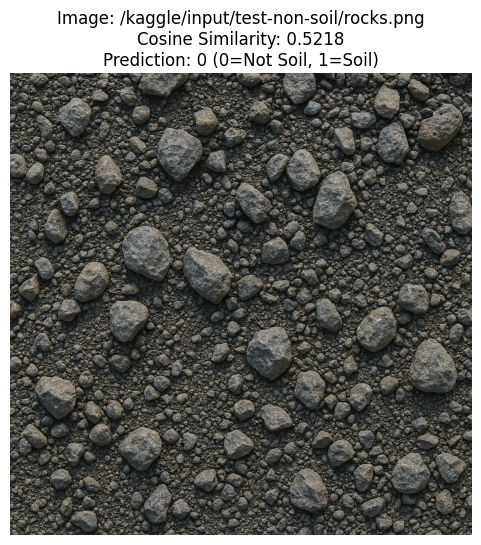

Unseen Image: /kaggle/input/test-non-soil/rocks.png, Cosine Similarity: 0.5218, Prediction: 0 (0=Not Soil, 1=Soil)


In [14]:
# Check prediction for unseen image (rock.png)
unseen_image_path = "/kaggle/input/test-non-soil/rocks.png"
try:
    with Image.open(unseen_image_path) as img:
        unseen_image = img.convert('RGB')
    unseen_tensor = transform(unseen_image).unsqueeze(0).to(device)
    with torch.no_grad():
        unseen_feature = model(unseen_tensor).cpu().numpy()
    unseen_feature_pca = pca.transform(unseen_feature)
    unseen_similarity = compute_top_k_similarity(unseen_feature_pca, train_features_pca, k=k)[0]
    unseen_label = 1 if unseen_similarity >= threshold else 0

    plt.figure(figsize=(6, 6))
    plt.imshow(unseen_image)
    plt.title(f"Image: {unseen_image_path}\nCosine Similarity: {unseen_similarity:.4f}\nPrediction: {unseen_label} (0=Not Soil, 1=Soil)")
    plt.axis('off')
    plt.show()

    print(f"Unseen Image: {unseen_image_path}, Cosine Similarity: {unseen_similarity:.4f}, Prediction: {unseen_label} (0=Not Soil, 1=Soil)")
except Exception as e:
    print(f"Error processing unseen image: {e}")